In [1]:
%load_ext autoreload 

In [2]:
autoreload 2

In [3]:
%matplotlib inline

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sym
import seaborn as sn

import pycollocation

Consider the following boundary value problem:
\begin{align}
    \frac{d T_1}{d_A} =& -q,\ T_1(0) = T_{1,0} \\
    \frac{d T_2}{d_A} =& -\frac{1}{2}q,\ T_2(A_{hx}) = T_{2,A_{hx}} \\
\end{align}
where $q = (T_1 - T_2)U$.

This boundary value problem describes a counter current heat exchanger; a hot liquid enters a device and exchanges heat across a metal plate with a cold liquid traveling through the device in the opposite direction. Here, $T_1$ is the temperature of the hot stream, $T_2$ is the temperature of the cold stream, $q$ is the rate of heat transfer from the hot fluid to the cold fluid, $U$ is the overall heat transfer coefficient and $A_hx$ is the total area of the heat exchanger.

In [5]:
# provide numerical values for the parameters
params = {'T10': 130, 'T2Ahx': 70, 'U': 1.0}

def q(T1, T2, U):
    return (T1 - T2) * U

def rhs(A, T1, T2, U, **params):
    return [-q(T1, T2, U), -0.5 * q(T1, T2, U)]

def bcs_lower(A, T1, T2, T10, **params):
    return [T1 - T10]

def bcs_upper(A, T1, T2, T2Ahx, **params):
    return [T2 - T2Ahx]

In [6]:
# specify an initial guess
domain = [0, 5.0]
ts = np.linspace(domain[0], domain[1], 1000)
T1s = np.repeat(0.5 * (params['T10'] + params['T2Ahx']), 1000)
initial_T1_poly = np.polynomial.Chebyshev.fit(ts, T1s, 15, domain)

initial_coefs = np.hstack([initial_T1_poly.coef, initial_T1_poly.coef])

In [7]:
problem = pycollocation.problems.TwoPointBVP(bcs_lower, bcs_upper, 1, 2, params, rhs)

In [8]:
polynomial_basis = pycollocation.basis_functions.PolynomialBasis()
polynomial_roots = polynomial_basis.nodes(15, domain, "Chebyshev")

In [9]:
solver = pycollocation.solvers.Solver(polynomial_basis)
solution = solver.solve({'kind': "Chebyshev", 'domain': domain}, initial_coefs,
                        polynomial_roots, problem)

In [10]:
T1_hat, T2_hat = solution.functions

In [11]:
As = np.linspace(domain[0], domain[1], 1000)

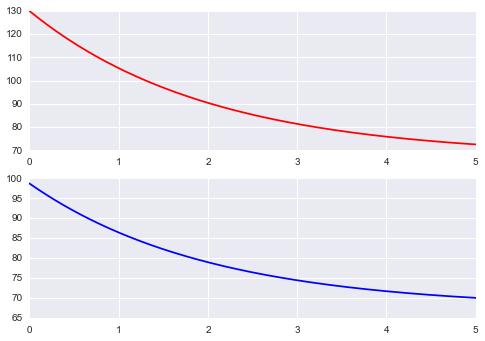

In [12]:
fig, axes = plt.subplots(2, 1)
axes[0].plot(As, T1_hat(As), color='r')
axes[1].plot(As, T2_hat(As), color='b')
plt.show()

In [13]:
pts = np.linspace(domain[0], domain[1], 1000)
T1_resids, T2_resids = solution.evaluate_residual(pts)

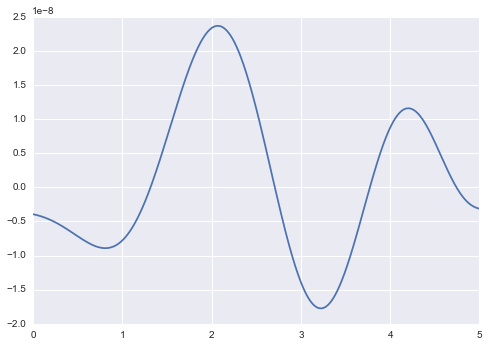

In [14]:
plt.plot(pts, T1_resids)
plt.show()

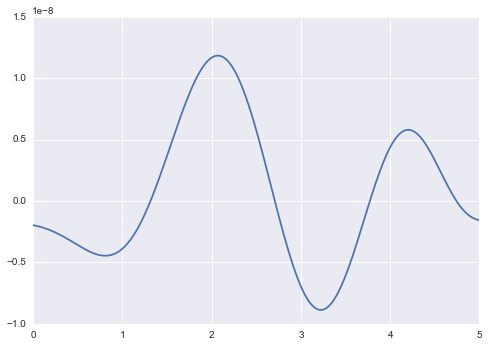

In [15]:
plt.plot(pts, T2_resids)
plt.show()